Sheet 1.2: RSA with politeness
==============================

**Author:** Michael Franke



This is a (numpy-based) Python implementation of an RSA model with a speaker who has two weighted objectives:
(i) being informative about the true world state and
(ii) being polite.
The latter is taken to mean that the speaker wants to increase the listener&rsquo;s degrees of beliefs in particular world states even if they are not true.

The same model is also covered in [chapter 9 of problang.org](http://www.problang.org/chapters/09-politeness.html) (Scontras et. al 2018).
The model covered here is essentially that of [Yoon et al. (2016)](http://langcog.stanford.edu/papers_new/yoon-2016-cogsci.pdf).



## Packages & helper functions



We use the same kinds of packages as before.



In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Also, we use the same helper functions as in Sheet 1.1 for computing soft-max and normalization of array dimensions.



In [1]:
##################################################
## helper functions
##################################################

def softmax(x, axis=1):
    """
    Softmax function in numpy
    Parameters
    ----------
    x: array
        An array with any dimensionality
    axis: int
        The axis along which to apply the softmax
    Returns
    -------
    array
        Same shape as x
    """
    e_x = np.exp(x - np.max(x, axis, keepdims=True))
    return e_x / e_x.sum(axis=axis, keepdims=True)


def normalize(arr, axis=1):
    """
    Normalize arr along axis
    """
    return arr / arr.sum(axis, keepdims=True)

## Running example



As a running example, we consider a context in which the speaker reports on their impression of the quality of the listener&rsquo;s self-baked cookies.

We assume that there are five world states, represented as increasing integers.
These numbers represent the true quality of the cookies (as perceived by the speaker).

We also assume that there are five expressions the speaker might want to use to report their quality assessment.
The semantic meaning we use for these expressions is a &ldquo;soft-semantics&rdquo; (truth-values are not confined to 0 and 1), which are derived from an experiment designed to elicit participants intuitions about the relevant semantic meanings ([Yoon et al. 2016](http://langcog.stanford.edu/papers_new/yoon-2016-cogsci.pdf)).



In [1]:
##################################################
## defining the context
##################################################

states     = [1,2,3,4,5]
utterances = ["terrible","bad","okay","good","amazing"]

semantic_meaning = np.array(
    [[.95 ,.85 ,.02 ,.02,.02],    # terrible
     [.85 ,.95 ,.02 ,.02,.02],    # bad
     [.02 ,.25 ,.95 ,.65,.35],    # okay
     [.02 ,.05 ,.55 ,.95,.93],    # good
     [.02 ,.02 ,.02 ,.65,.95]]    # amazing
)

> <strong><span style=&ldquo;color:#D83D2B;&rdquo;>Exercise 1.2.1: Check experiment and your intuitions</span></strong>
>
> 1. Consult the original paper ([Yoon et al. 2016](http://langcog.stanford.edu/papers_new/yoon-2016-cogsci.pdf)) to find the description of the experiment that was used to get these semantic values. Describe this experiment in at most three simple sentences: what was the question participants had to answer and how were answers recorded?
> 2. Comment on whether you find the obtained values intuitive as values of the semantic meaning of these expression.
> 3. Do you think that the experiment was well-designed for the task of eliciting information about semantic meaning of expressions?



## The model and its parameters



The polite-language model is defined as follows:

\begin{align*}
P_{lit}(s \mid u) & \propto L(u,s) \\
P_{S}( u \mid s, {\color{3F9786}{\varphi}}) & = \mathrm{SoftMax}\left ( \alpha  U (s, u,  {\color{3F9786}{\varphi}}) \right) \\
U (s, u,  {\color{3F9786}{\varphi}}) & = {\color{3F9786}{\varphi}} \ \log P_{lit}(s \mid u) + (1-{\color{3F9786}{\varphi}}) \sum_{s'} P_{lit}(s' \mid u) \ V(s') \\
P_{L}( s, {\color{3F9786}{\varphi}} \mid u) & \propto P(s) \ P({\color{3F9786}{\varphi}}) \ P_{S_1}( u \mid s, {\color{3F9786}{\varphi}})
\end{align*}

The key novelty is a composite utility function for the speaker, which is defined as a weighted sum (with weight $\varphi$) over two components: epistemic and social utility.
We assume here that the value function $V(s)$ is a linear function of the star rating: $V(s) = v s$, where $v$ is a model parameter called &ldquo;social value&rdquo;.

In sum, this model has free parameters $\alpha$, $\varphi$ and $v$.



In [1]:
##################################################
## model parameters
##################################################

alpha        = 10
phi          = 0.99
social_value = 1.25

## Implementation and visualization



Let&rsquo;s look at the speaker and listener part separately.



### Polite speakers



terrible   bad  okay  good  amazing  object
1      0.75  0.25  0.00  0.00     0.00       1
2      0.25  0.75  0.00  0.00     0.00       2
3      0.00  0.00  1.00  0.00     0.00       3
4      0.00  0.00  0.03  0.40     0.57       4
5      0.00  0.00  0.00  0.01     0.99       5

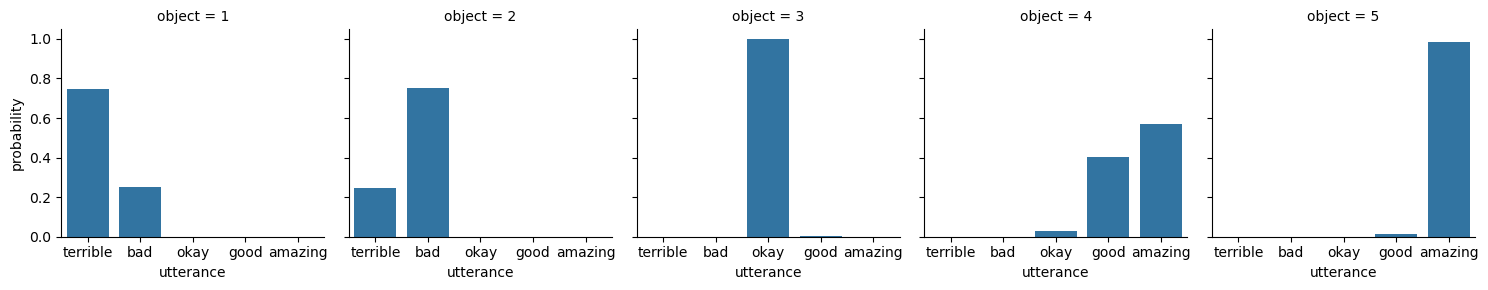

In [1]:
##################################################
## RSA speaker with politeness
##################################################

def RSA_polite_speaker(alpha, phi, social_value):
    """
    predictions of an RSA model with politeness (speaker part)
    (following: http://www.problang.org/chapters/09-politeness.html)
    Parameters
    ----------
    alpha: float
        Optimality parameter
    phi: float
        Relative weight of epistemic utility component
    social_value: float
        Social value factor (how much more "socially valuable" is one more star?)
    Returns
    -------
    array
        probability that speaker chooses utterance for each state
    """
    literal_listener   = normalize(semantic_meaning)
    epistemic_utility  = np.log(np.transpose(literal_listener))
    social_utility     = np.sum(literal_listener * np.array([states]) * social_value, axis=1)
    util_speaker       = phi * epistemic_utility + (1-phi) * social_utility
    pragmatic_speaker  = softmax(alpha * util_speaker)
    return(pragmatic_speaker)

RSA_speaker_predictions = RSA_polite_speaker(alpha, phi, social_value)

##################################################
## showing and plotting the results
##################################################

speaker  = pd.DataFrame(data    = RSA_speaker_predictions,
                        index   = states,
                        columns = utterances)
speaker['object'] = speaker.index

print(speaker.round(2))

speaker_long = speaker.melt(id_vars      = "object",
                            var_name     = "utterance",
                            value_name   = "probability",
                            ignore_index = False)
speaker_plot = sns.FacetGrid(speaker_long, col="object")
speaker_plot.map(sns.barplot, "utterance", "probability")
plt.show()

> <strong><span style=&ldquo;color:#D83D2B;&rdquo;>Exercise 1.2.2: Explore the polite speaker model</span></strong>
>
> 0. For yourself, in order to understand the model, go through each line of the definition of the function \`RSA<sub>polite</sub><sub>speaker</sub>\` and make sure that you understand what is happening.
> 1. Change the call to the speaker to make it so that it only cares about making the listener feel good. What parameter value(s) did you choose?
> 2. Change the call to the speaker to make it so that it cares about both making the listener feel good *and* conveying information. What parameter value(s) did you choose?
> 3. If we set $\varphi=1$, and choose a very high $\alpha$, the speaker behavior is quite regular. Is this kind of behavior intuitive? Do you think it happens in real life?
> 4. Is there a parameter setting for this model, such that the speaker would also at most choose when category higher when trying to polite? For example, when they should informatively say &rsquo;okay&rsquo;, they would say &rsquo;good&rsquo;, but never &rsquo;amazing&rsquo;. Which parameters achieve this? Or, how could the model be changed to achieve this behavior?



### Pragmatic listener reasoning about politeness



The pragmatic listener is more complicated for this model.
This is a form of *joint-inference* where more than one variable of interest is inferred.
Concretely, the pragmatic listener jointly infers the world state and the degree of honesty/politeness.
For ease of implementation, we discretize the set of possible values for $\varphi$.



listener posterior over states after hearing 'good':
 [0.00588069 0.01970965 0.40323864 0.53989896 0.03127205]
plotting listener posterior for utterance: amazing

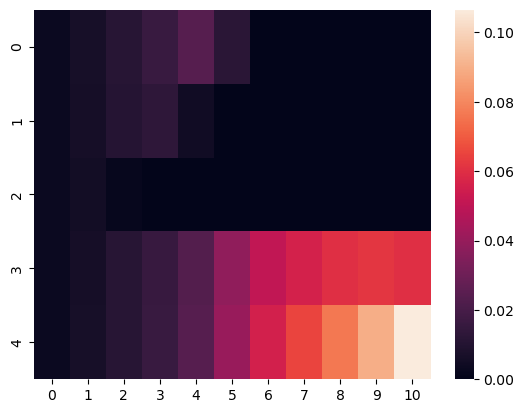

In [1]:
##################################################
## pragmatic listener infers politeness level
##################################################

# which phi-values to consider
phi_marks     = np.linspace(start=0, stop=1, num=11)
phi_prior_flt = np.array([1,1,1,1,1,1,1,1,1,1,1])   # flat
phi_prior_bsd = np.array([1,2,3,4,5,6,7,8,9,10,11]) # biased towards politeness

def RSA_polite_listener(alpha, phi_prior, social_value):
    """
    predictions of an RSA model with politeness (listener part)
    (following: http://www.problang.org/chapters/09-politeness.html)
    Parameters
    ----------
    alpha: float
        Optimality parameter
    phi_priors: float
        Prior over degree of politeness (phi-parameter)
    social_value: float
        Social value factor (how much more "socially valuable" is one more star?)
    Returns
    -------
    array
         for each message: listener posterior over state-phi pairs
    """
    phi_prior = phi_prior / np.sum(phi_prior) # make sure priors are normalized
    posterior = np.zeros((len(utterances), len(states),len(phi_marks)))
    for i in range(len(phi_marks)):
        pragmatic_speaker   = RSA_polite_speaker(alpha, phi_marks[i], social_value)
        posterior_given_phi = normalize(np.transpose(pragmatic_speaker), axis=1)
        posterior[:,:,i]    = posterior_given_phi * phi_prior[i]
    return(posterior)

RSA_listener_predictions = RSA_polite_listener(alpha, phi_prior_bsd, social_value)

print("listener posterior over states after hearing 'good':\n",
      np.sum(RSA_listener_predictions[3,:,:], axis=1))

# TODO: why are the values numerically slightly off wrt to the WebPPL implementation?
# TODO: cast the 3D array into DataFrame for plotting

iterables=[utterances, states, phi_marks]
index = pd.MultiIndex.from_product(iterables, names=['utterances','states','phi'])

listener = pd.DataFrame(RSA_listener_predictions.reshape(RSA_listener_predictions.size, 1),
                        index=index)
listener = listener.reset_index()

##################################################
## plotting the results
##################################################

def plot_listener(utterance_index):
    print("plotting listener posterior for utterance:", utterances[utterance_index])
    predictions = RSA_listener_predictions[utterance_index,:,:]
    sns.heatmap(predictions)
    plt.show()

plot_listener(4)

> <strong><span style=&ldquo;color:#D83D2B;&rdquo;>Exercise 1.2.3: Explore the pragmatic listener</span></strong>
>
> 0. For yourself, in order to understand the model, go through each line of the definition of the function \`RSA<sub>polite</sub><sub>listener</sub>\` and make sure that you understand what is happening.
> 1. What does the heatmap show? What&rsquo;s on the x-axis, what&rsquo;s on the y-axis, and what do the colors mean?
> 2. Add a function that takes an utterance index (0, &#x2026;, 4) and outputs three things: (i) a print out of the [marginal distribution](https://en.wikipedia.org/wiki/Marginal_distribution) over states, (ii) a print out of the marginal distribution over $\varphi$ values, and (iii) the heatmap visualizing the joint-distribution of both.
> 3. Compare the interpretation of the utterance &rsquo;amazing&rsquo; with that of the other utterances (for the parameter values used originally). Explain in what sense the distribution shown for &rsquo;amazing&rsquo; is a [multimodal distribution](https://en.wikipedia.org/wiki/Multimodal_distribution). Explain why the model makes this multi-modal prediction for &rsquo;amazing&rsquo;. Does it also predict multi-modality for &rsquo;good&rsquo;? What about &rsquo;terrible&rsquo;?



## References



Scontras, G., Tessler, M. H., & Franke, M. (2018). [Probabilistic language understanding: An introduction to the Rational Speech Act framework](http://www.problang.org).

Yoon, E. J., Tessler, M. H., Goodman, N. D., & Frank, M. C. (2016). [Talking with tact: polite language as a balance between kindness and informativity](http://langcog.stanford.edu/papers_new/yoon-2016-cogsci.pdf). In: *Proceedings of CogSci* 38.

